In [1]:
%pip install -qU pandas langchain-openai scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [31]:
# read data in stack-overflow-data.csv

import pandas as pd

df = pd.read_csv('stack-overflow-data.csv')

df.head(10)


,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


In [32]:
# how many tags are there in total?
print(df['tags'].nunique())


20


### Generate Embeddings

In [33]:

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
)


In [34]:
def get_embedding(texts:list[str]):
    return embeddings.embed_documents(texts)


texts = df['post'].tolist()

embeddings = get_embedding(texts)

df['embedding'] = embeddings

In [35]:
# export data with embeddings to csv
# df.to_csv('stack-overflow-data-with-embeddings.csv', index=False)

# Visualization

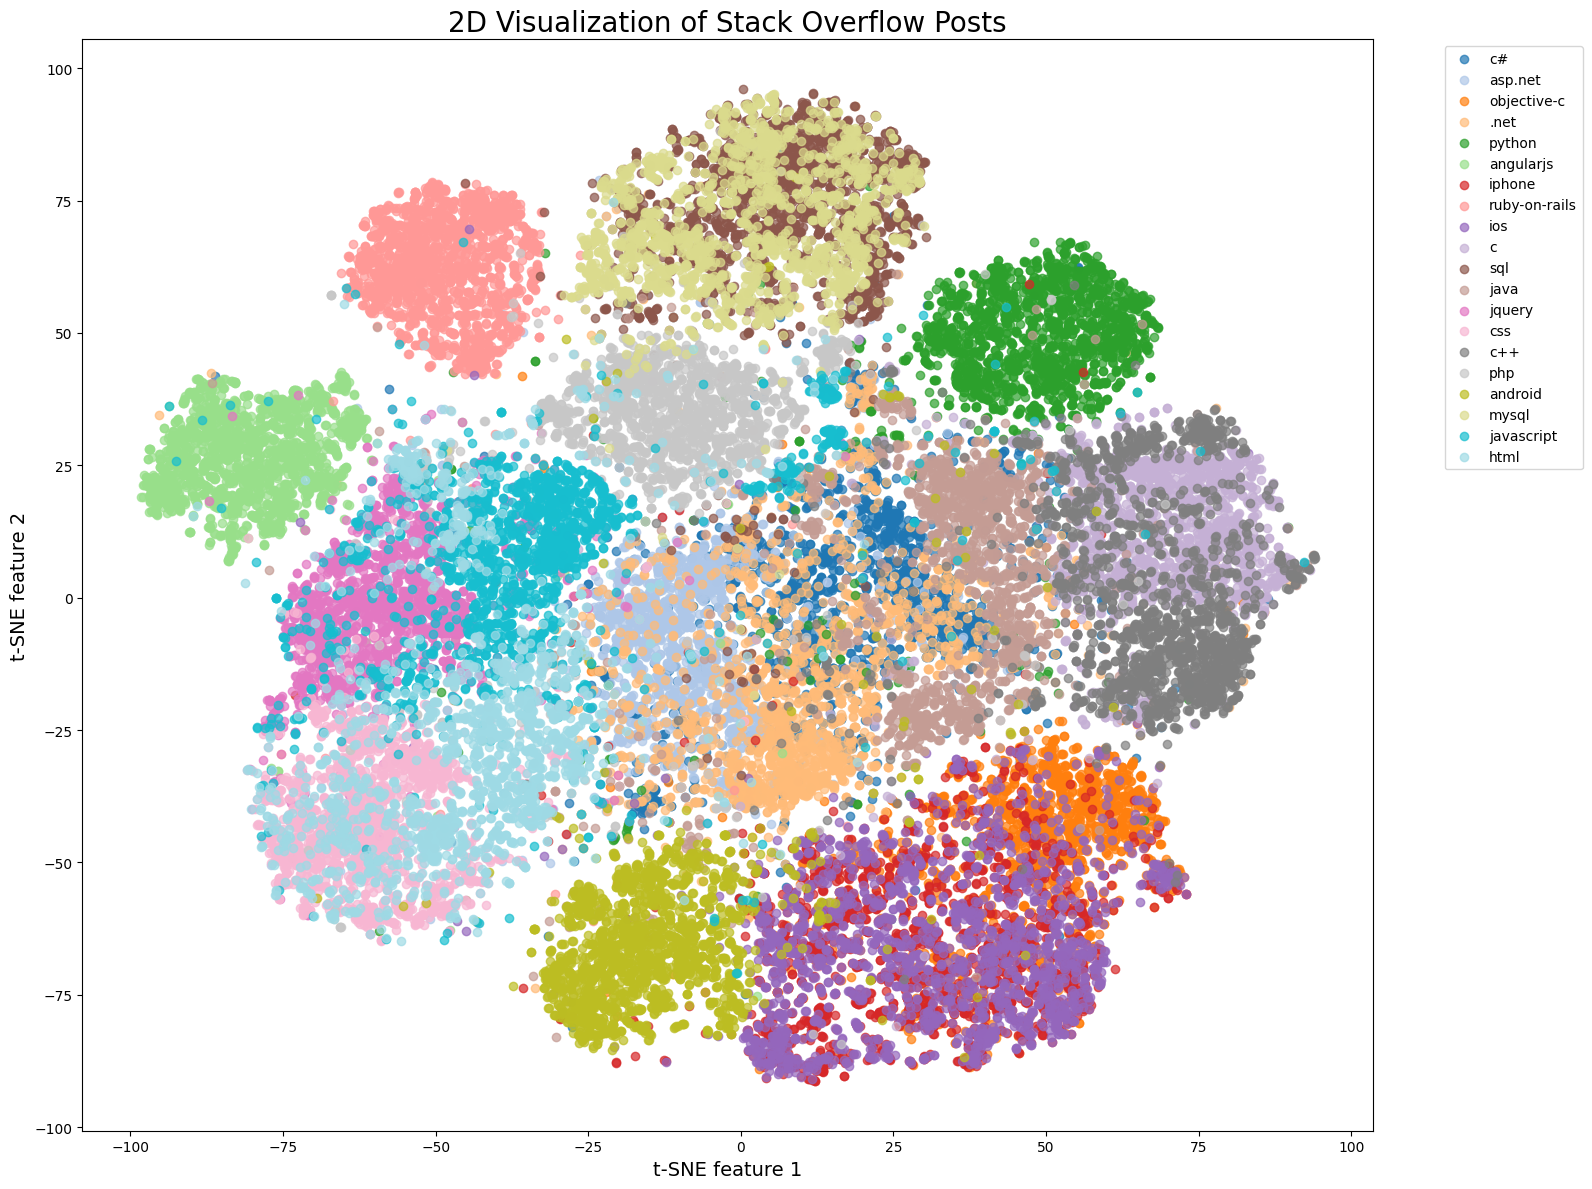

In [36]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert embeddings to a numpy array
embedding_array = np.array(df['embedding'].tolist())

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embedding_array)

# Create a scatter plot
plt.figure(figsize=(16, 12))

# Get unique tags and assign colors
unique_tags = df['tags'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_tags)))

# Plot each tag separately
for i, tag in enumerate(unique_tags):
    mask = df['tags'] == tag
    plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], c=[colors[i]], label=tag, alpha=0.7)

# Add labels and title
plt.title('2D Visualization of Stack Overflow Posts', fontsize=20)
plt.xlabel('t-SNE feature 1', fontsize=14)
plt.ylabel('t-SNE feature 2', fontsize=14)

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()

# Show the plot
plt.show()

# Prediction using K-Nearest Neighbors

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Convert embeddings to a numpy array
embedding_array = np.array(df['embedding'].tolist())

# Encode the tags as integers
df['tag_code'] = df['tags'].astype('category').cat.codes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embedding_array, df['tag_code'], test_size=0.25, random_state=42)

# Initialize the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=40)

# Train the classifier
knn.fit(X_train, y_train)

# Predict the tags for the test set
y_pred = knn.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=df['tags'].astype('category').cat.categories))

Accuracy: 0.8376
Classification Report:
                precision    recall  f1-score   support

         .net       0.79      0.60      0.68       518
      android       0.95      0.96      0.95       507
    angularjs       0.96      0.99      0.98       493
      asp.net       0.74      0.89      0.81       479
            c       0.84      0.96      0.90       495
           c#       0.76      0.75      0.75       484
          c++       0.92      0.83      0.87       490
          css       0.76      0.96      0.85       504
         html       0.85      0.64      0.73       524
          ios       0.67      0.59      0.63       487
       iphone       0.62      0.68      0.65       510
         java       0.93      0.91      0.92       500
   javascript       0.87      0.78      0.82       512
       jquery       0.81      0.92      0.86       472
        mysql       0.81      0.91      0.86       493
  objective-c       0.73      0.72      0.73       496
          php       0.9

# Prediction using Centroid computation

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scipy.spatial.distance import cdist

# Compute centroids for each tag
centroids = {}
for tag in df['tag_code'].unique():
    centroids[tag] = X_train[y_train == tag].mean(axis=0)

# Convert centroids to a numpy array
centroid_array = np.array([centroids[tag] for tag in sorted(centroids.keys())])

# Predict the tag for each test sample
def predict_tag(embedding, centroids):
    distances = cdist([embedding], centroids, metric='euclidean')
    return np.argmin(distances)

y_pred = [predict_tag(embedding, centroid_array) for embedding in X_test]

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=df['tags'].astype('category').cat.categories))


Accuracy: 0.8635
Classification Report:
                precision    recall  f1-score   support

         .net       0.73      0.73      0.73       518
      android       0.96      0.97      0.96       507
    angularjs       0.99      1.00      0.99       493
      asp.net       0.81      0.80      0.80       479
            c       0.90      0.96      0.93       495
           c#       0.80      0.77      0.78       484
          c++       0.96      0.88      0.91       490
          css       0.82      0.93      0.87       504
         html       0.82      0.74      0.78       524
          ios       0.67      0.69      0.68       487
       iphone       0.71      0.62      0.66       510
         java       0.93      0.95      0.94       500
   javascript       0.89      0.86      0.87       512
       jquery       0.87      0.92      0.90       472
        mysql       0.91      0.86      0.88       493
  objective-c       0.74      0.75      0.74       496
          php       0.9